Generating S14 Fig, to validate that the 42bp-mEGFP fusion is equivalent to FCY1-mEGFP and mEGFP at the FCY1 locus

In [3]:
import numpy as np
import pandas as pd
import os
import glob
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
plt.rcParams['savefig.dpi'] = 600
from matplotlib import cm
import matplotlib.colors as colors

### Importing the fluorescence data

In [5]:
plate_info = pd.read_csv("Data_for_SFigs/plate_2024_01_17.csv")
plate_info = plate_info.dropna(subset=['Construction']).reset_index(drop=True)

In [6]:
# Dict with info on each well

well_dict = {}

for row in range(plate_info.shape[0]):
    
    if np.isnan(plate_info.at[row, 'Clone']):
        continue
        
    well = plate_info.at[row, 'Well']
    
    construct = plate_info.at[row, 'Construction']
    clone = int(plate_info.at[row, 'Clone'])
    background = plate_info.at[row, 'Background']
    
    well_dict[well] = [construct, clone, background]

In [7]:
# Generating model and template dfs
model_cyto = pd.DataFrame(columns=['Well', 'Background', 'Construction', 'Clone', "FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"])
data_cyto = model_cyto.copy()

In [8]:
# Obtaining the list of files
os.chdir("Data_for_SFigs/2024-01-17_at_02-46-44pm")
files_list = glob.glob('*.csv')

# Filling the dataframe of fluorescence intensities
for cyto_csv in files_list:
    
    current_df = model_cyto.copy()
    
    well = cyto_csv.split('.')[1]
    background = well_dict[well][2]
    construct = well_dict[well][0]
    clone = well_dict[well][1]
    
    data_all = pd.read_csv(cyto_csv)
    current_df[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]] = data_all[["FSC-HLin", "SSC-HLin", "GRN-B-HLin", "YEL-B-HLin"]].copy()
    
    current_df['Well'] = well
    current_df['Background'] = background
    current_df['Construction'] = construct
    current_df['Clone'] = clone
    
    data_cyto = pd.concat([data_cyto, current_df]).reset_index(drop=True)

# Go back to starting directory
os.chdir('..')
os.chdir('..')

C:\Users\tiger\AppData\Local\Temp\ipykernel_12768\2083277339.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_cyto = pd.concat([data_cyto, current_df]).reset_index(drop=True)


### Normalizing the fluorescence intensities

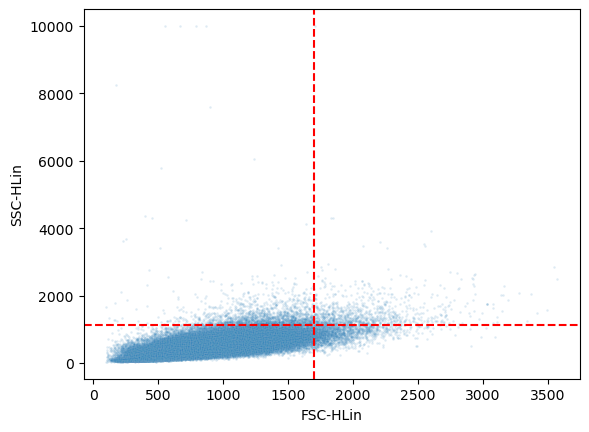

In [10]:
# Setting and validating thresholds for FSC and SSC
max_FSC = np.percentile(data_cyto['FSC-HLin'], 99)
max_SSC = np.percentile(data_cyto['SSC-HLin'], 99)

sns.scatterplot(data=data_cyto, x='FSC-HLin', y='SSC-HLin', alpha=0.15, s=3)
plt.axhline(y=max_SSC, c='red', linestyle='--')
plt.axvline(x=max_FSC, c='red', linestyle='--')

In [11]:
# Applying the thresholds
data_cyto = data_cyto[(data_cyto['FSC-HLin'] < max_FSC) & (data_cyto['SSC-HLin'] < max_SSC)].copy().reset_index(drop=True)

In [12]:
# Dividing by the FSC
data_cyto['GRN-B-HLin'] = data_cyto['GRN-B-HLin'] / data_cyto['FSC-HLin']
data_cyto['YEL-B-HLin'] = data_cyto['YEL-B-HLin'] / data_cyto['FSC-HLin']

# Generating log10-scaled columns
data_cyto['Log10_GRN'] = np.log10(data_cyto['GRN-B-HLin'])
data_cyto['Log10_YEL'] = np.log10(data_cyto['YEL-B-HLin'])

F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
F:\Anaconda_SA\envs\FCY1prom_final\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
# Renaming the WT
data_cyto['Construction'] = data_cyto['Construction'].apply(lambda x: 'Wild-type' if x=='Mat-alpha control' else x)

In [14]:
# Only the mEGFP constructions are selected
gfp_constructs = ['mEGFP',  'FCY1-mEGFP', '42bp-mEGFP', 'Wild-type']
# The 21bp-mEGFP construct is also removed, as it was not used and is not a relevant comparison
data_gfp = data_cyto[data_cyto['Construction'].isin(gfp_constructs)].copy().reset_index(drop=True)

# Two FCY1-mEGFP clones which were unsuccessful (same fluorescence as WT control) are removed from the df
data_gfp = data_gfp[(data_gfp['Construction'] != 'FCY1-mEGFP') | (~data_gfp['Clone'].isin([3, 4]))]

In [15]:
medians_lin = data_gfp.drop(columns=['Well']).groupby(by=['Construction', 'Clone', 'Background'], as_index=False).median()

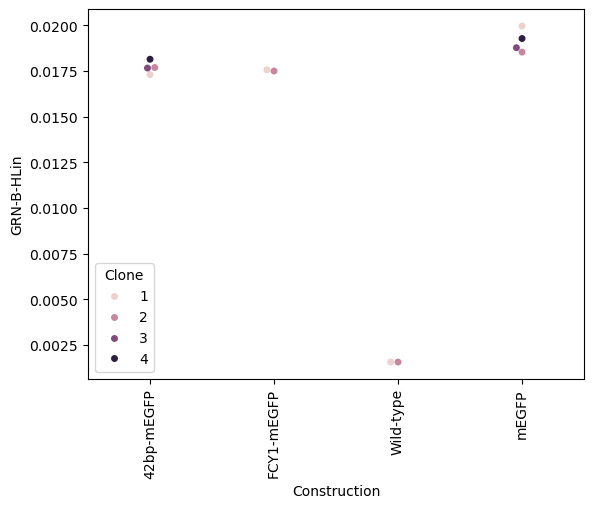

In [16]:
sns.swarmplot(data=medians_lin[medians_lin['Background']=='AKD1123'], x='Construction', y='GRN-B-HLin', hue='Clone')
plt.tick_params(axis='x', labelrotation=90)

### Generating the figure

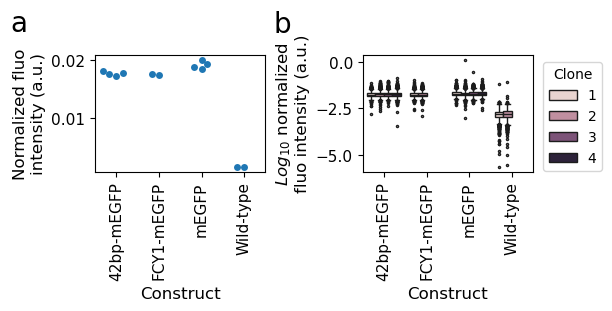

In [39]:
plt.rcParams['savefig.dpi'] = 600
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 11

fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

order_con=['42bp-mEGFP', 'FCY1-mEGFP', 'mEGFP', 'Wild-type']

sns.swarmplot(data=medians_lin[medians_lin['Background']=='AKD1123'], x='Construction', y='GRN-B-HLin', ax=axs[0], order=order_con)

log_boxes = sns.boxplot(data=data_gfp[data_gfp['Background']=='AKD1123'], x='Construction', y='Log10_GRN', hue='Clone', ax=axs[1],
                        order=order_con, flierprops={'markersize':1.5})
sns.move_legend(log_boxes, "upper left", bbox_to_anchor=(1.02, 1))

for ax in [axs[0], axs[1]]:
    ax.set_xlabel('Construct')
    ax.tick_params(axis='x', labelrotation=90)

axs[0].set_ylabel('Normalized fluo\nintensity (a.u.)')
axs[1].set_ylabel(r"$Log_{10}$" ' normalized' '\n' 'fluo intensity (a.u.)')

# Identifying the two plots
axs[0].annotate('a', (-2.50, 0.025), fontsize=20, annotation_clip=False)
axs[1].annotate('b', (-2.60, 1.61), fontsize=20, annotation_clip=False)

FigS14 = plt.gcf()
FigS14.savefig('Supp_figs/S14Fig.tiff', bbox_inches='tight')